Loading Libraries and Reading Data In

In [5]:
!pip install statsmodels
!pip install patsy

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [6]:
# import packages for analysis and modeling
import pandas as pd  # data frame operations
import numpy as np #arrays and math functions
import statsmodels.api as sm #stat models (regression)
import matplotlib.pyplot as plt #2d plotting
from pandas.tools.plotting import scatter_matrix  # scatter plot matrix
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
from sklearn.tree import DecisionTreeRegressor  # machine learning tree
from sklearn.ensemble import RandomForestRegressor # ensemble method
from sklearn.preprocessing import Imputer
%config IPCompleter.greedy=True #tabbing for autocomplete
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING



Cleaning Data - Coaches

In [7]:
# check the structure of the coaches data frame 
print(coaches.df.shape)  #124 obeservations by 7 feature

print('Below are counts of null observations by column:')
nullcounts = coaches.df.isnull().sum() #Number of missing values in the coaches dataframe per column
print(nullcounts) #8 coaches have no salary listed


#Replace OtherPay and Maxbonus NA/s with average of column
coaches.df["OtherPay"].fillna(coaches.df["OtherPay"].mean(),inplace=True)
coaches.df["MaxBonus"].fillna(coaches.df["MaxBonus"].mean(), inplace=True)

print('The following counts are average salary, average other pay and average TotalSalary:')
#Print Averages of  Salary Columns
print(np.mean(coaches.df.Salary)) #Average Salary 
print(np.mean(coaches.df.OtherPay)) #Average Other Pay
print(np.mean(coaches.df.TotalSalary)) #Average Total Salary


#Recheck NA Count after cleansing
coaches.df = coaches.df[np.isfinite(coaches.df['TotalSalary'])] #remove 8 obs. where salary is not listed (won't help with regression)
print(coaches.df.shape)

print('Below are counts of null observations by column:')
nullcounts = coaches.df.isnull().sum() #Number of missing values in the coaches dataframe per column
print(nullcounts) #8 coaches have no salary listed


NameError: name 'coaches' is not defined

Cleaning Data - NCAA

In [3]:
# check the structure of the coaches data frame 
print(ncaa.df.shape)  #345 obeservations by 227 feature

ncaa.df = ncaa.df.filter(regex='2006|SCL') #keeping data from year = 2006 (.filter + regex (contains))
ncaa.df = pd.DataFrame(ncaa.df) #store result as dataframe

ncaa.df["School"] = ncaa.df["SCL_NAME"]
ncaa.df.drop(['SCL_UNITID'], axis = 1, inplace = True) #SCL UnitID is useless index column. Drop
ncaa.df.drop(['SCL_NAME'], axis = 1, inplace = True) #SCL UnitID is useless index column. Drop

print('Below are counts of null observations by column:')
nullcounts.ncaa = ncaa.df.isnull().sum() #Number of missing values 
print(nullcounts.ncaa) #Checking Nulls





(345, 226)
Below are counts of null observations by column:
SCL_DIVISION               0
SCL_SUBDIVISION            0
SCL_CONFERENCE             0
SCL_HBCU                   0
SCL_PRIVATE                0
FED_N_2006_SA              0
FED_RATE_2006_SA           0
GSR_N_2006_SA              0
GSR_2006_SA                0
FED_RATE_MALE_2006_SA      0
FED_RATE_FEMALE_2006_SA    0
GSR_MALE_2006_SA           0
GSR_FEMALE_2006_SA         0
FED_RATE_2006_SB           0
FED_RATE_MALE_2006_SB      0
FED_RATE_FEMALE_2006_SB    0
School                     0
dtype: int64


Merging Data on SchoolName

In [4]:
#Matching: https://github.com/RobinL/fuzzymatcher/blob/master/examples.ipynb
!pip install python_Levenshtein-0.12.0-cp36-cp36m-win_amd64.whl 
##need to downloadLevenshtein-0.12.0-cp36-cp36m-win_amd64.whl from https://www.lfd.uci.edu/~gohlke/pythonlibs/#python-levenshtein
!pip install fuzzymatcher
import fuzzymatcher

left_on = ["School", "Conference"] 
right_on = ["School", "SCL_CONFERENCE"]

dfjoined = fuzzymatcher.fuzzy_left_join(coaches.df,ncaa.df, left_on, right_on) #Merge on School and Conference
dfjoined = pd.DataFrame(dfjoined) #Dataframe creation
dfjoined = dfjoined.sort_values(by='best_match_score', ascending = False) #
dfjoined = dfjoined.query('best_match_score > -1') #removing rows where best_match_score < 0

col= dfjoined.columns.tolist()
col

#df of only desired columns. Removing all salary info besides 'totalsalary'
df = dfjoined[['Name',
'School_right',
 'Conference',
 'TotalSalary',
 'SCL_PRIVATE',
 'FED_N_2006_SA',
 'FED_RATE_2006_SA',
 'GSR_N_2006_SA',
 'GSR_2006_SA',
 'FED_RATE_2006_SB']]

#df with grad rates and coaches data = dfjoined.


#load in data pertaining to stadium size
#https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_stadiums
stadiums = pd.read_csv('/Users/jdine/Desktop/SYracuse/Term 5 - Current/Advanced Info Analytics- IST 718/Homework/Lab1/NCAAstadiums.csv.')
stadiums.head()
df.head()

#Merge stadium capacity onto exisiting df
l_on = ["School_right", "Conference"] 
r_on = ["School", "Conference"]

df = fuzzymatcher.fuzzy_left_join(df , stadiums, l_on, r_on) #Merge on School and Conference

#Only Keep Desired Features
df = df[['Name',
'School_right',
 'Conference_left',
 'TotalSalary',
 'SCL_PRIVATE',
 'FED_RATE_2006_SA',
 'GSR_2006_SA',
 'Capacity']]

#Map Attendace Data (2016)
attendance = pd.read_csv('/Users/jdine/Desktop/SYracuse/Term 5 - Current/Advanced Info Analytics- IST 718/Homework/Lab1/2017AttendanceFBS.csv.')
df = fuzzymatcher.fuzzy_left_join(df , attendance, "School_right", "SchoolWiki") #Merge on School and Conference


#Only Keep Desired Features
df = df[['Name',
'School_right',
 'Conference_left',
 'TotalSalary',
 'SCL_PRIVATE',
 'FED_RATE_2006_SA',
 'GSR_2006_SA',
 'Capacity',
 'AverageAttendance2016',
 'Stadium Capacity Filled (2016)']]

#Map 2017 Records
records = pd.read_csv('/Users/jdine/Desktop/SYracuse/Term 5 - Current/Advanced Info Analytics- IST 718/Homework/Lab1/Records2017.csv.')
df = fuzzymatcher.fuzzy_left_join(df , records, "School_right", "School") #Merge on School and Conference

#Only Keep Desired Features
df = df[['Name',
'School_right',
 'Conference_left',
 'TotalSalary',
 'SCL_PRIVATE',
 'FED_RATE_2006_SA',
 'GSR_2006_SA',
 'Capacity',
 'AverageAttendance2016',
 'Stadium Capacity Filled (2016)',
 'W',
 'L',
 'Pct']]



df.head()

#I had to continuously remove columns in this block due to the way the fuzzymatcher distribution outputs results on a merged dataframe.



Processing c:\users\jdine\documents\python_levenshtein-0.12.0-cp36-cp36m-win_amd64.whl


Requirement 'python_Levenshtein-0.12.0-cp36-cp36m-win_amd64.whl' looks like a filename, but the file does not exist
Exception:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\basecommand.py", line 215, in main
    status = self.run(options, args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\commands\install.py", line 335, in run
    wb.build(autobuilding=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\wheel.py", line 749, in build
    self.requirement_set.prepare_files(self.finder)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\req\req_set.py", line 380, in prepare_files
    ignore_dependencies=self.ignore_dependencies))
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\req\req_set.py", line 620, in _prepare_file
    session=self.session, hashes=hashes)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\download.py", line 809, in unpack_url
    unpack_file_url(link, location, download_dir, hashes=hashes)


  Using cached python-Levenshtein-0.12.0.tar.gz
  Using cached fuzzywuzzy-0.16.0-py2.py3-none-any.whl
  Running setup.py bdist_wheel for python-Levenshtein: started
  Running setup.py bdist_wheel for python-Levenshtein: finished with status 'done'
  Stored in directory: C:\Users\jdine\AppData\Local\pip\Cache\wheels\c0\83\e9\b2cc2876e175d04091caf4e9f5de564ff2503b1f1885e7c3ba
Successfully built python-Levenshtein


,Name,School_right,Conference_left,TotalSalary,SCL_PRIVATE,FED_RATE_2006_SA,GSR_2006_SA,Capacity,AverageAttendance2016,Stadium Capacity Filled (2016),W,L,Pct
0,Dana Holgorsen,West Virginia University,Big 12,2380000.0,0.0,65.0,92.0,60000.0,57583.0,0.96,7.0,6.0,0.538
1,Todd Berry,University of Louisiana at Monroe,Sun Belt,250000.0,0.0,38.0,47.0,30427.0,12610.0,0.41,4.0,8.0,0.333
2,Bobby Hauck,University of Nevada-Las Vegas,Mt. West,500900.0,0.0,63.0,74.0,26000.0,18501.0,0.62,5.0,7.0,0.417
3,Joey Jones,University of South Alabama,Sun Belt,371125.0,0.0,68.0,74.0,40000.0,16250.0,0.49,4.0,8.0,0.333
4,Mark Hudspeth,University of Louisiana at Lafayette,Sun Belt,803000.0,0.0,75.0,80.0,30427.0,20224.0,0.65,5.0,7.0,0.417


#Summary Statistics and Visuals

        TotalSalary  SCL_PRIVATE  FED_RATE_2006_SA  GSR_2006_SA  \
count  1.130000e+02   113.000000        113.000000    113.00000   
mean   1.587149e+06     0.150442         63.380531     80.79646   
std    1.158124e+06     0.359097         18.870006      9.70011   
min    2.500000e+05     0.000000        -99.000000     41.00000   
25%    5.453000e+05     0.000000         58.000000     75.00000   
50%    1.350000e+06     0.000000         65.000000     81.00000   
75%    2.406505e+06     0.000000         71.000000     87.00000   
max    5.476738e+06     1.000000         93.000000     97.00000   

            Capacity  AverageAttendance2016  Stadium Capacity Filled (2016)  \
count     112.000000             111.000000                      111.000000   
mean    54391.026786           41906.369369                        0.785766   
std     24036.237399           26210.383713                        0.191575   
min     22113.000000            7789.000000                        0.310000   
2

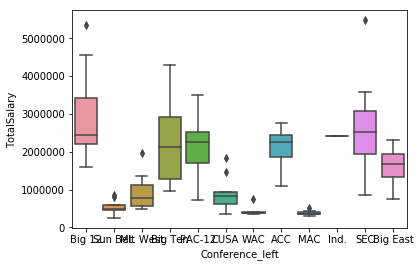

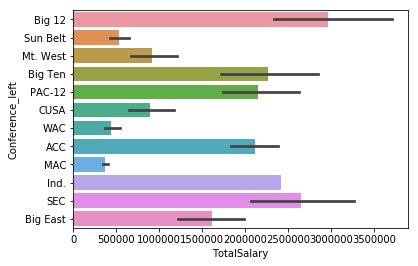

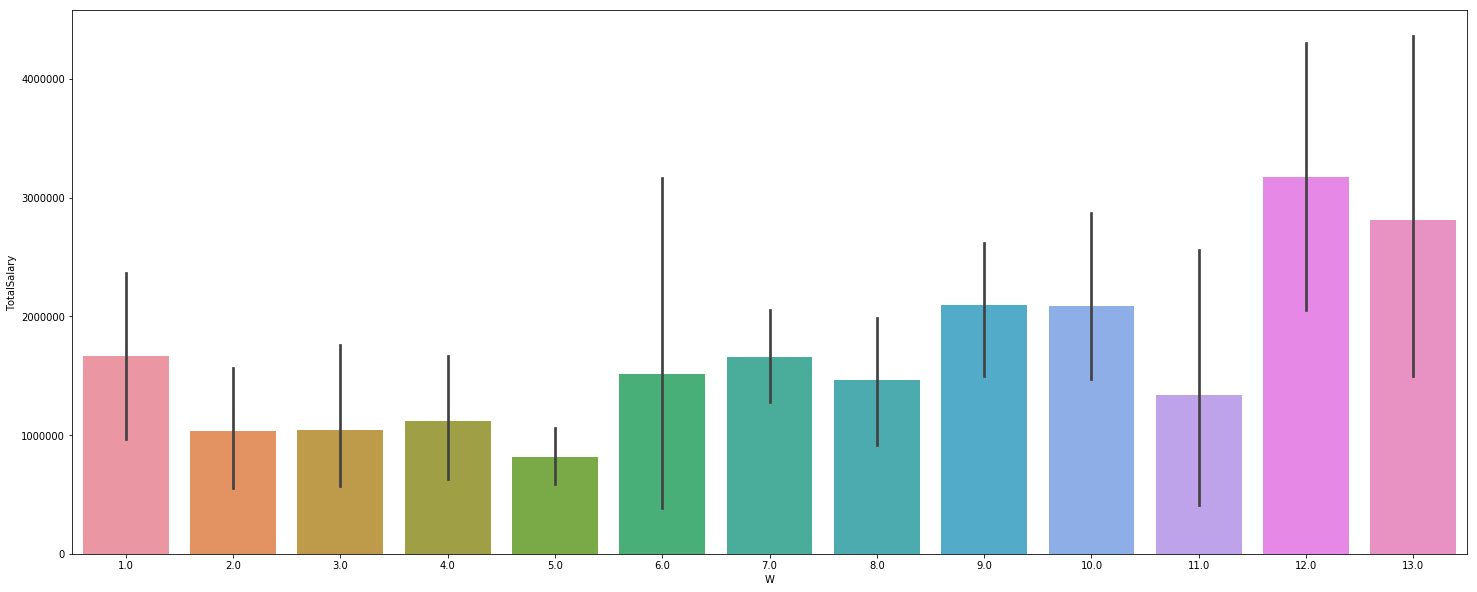

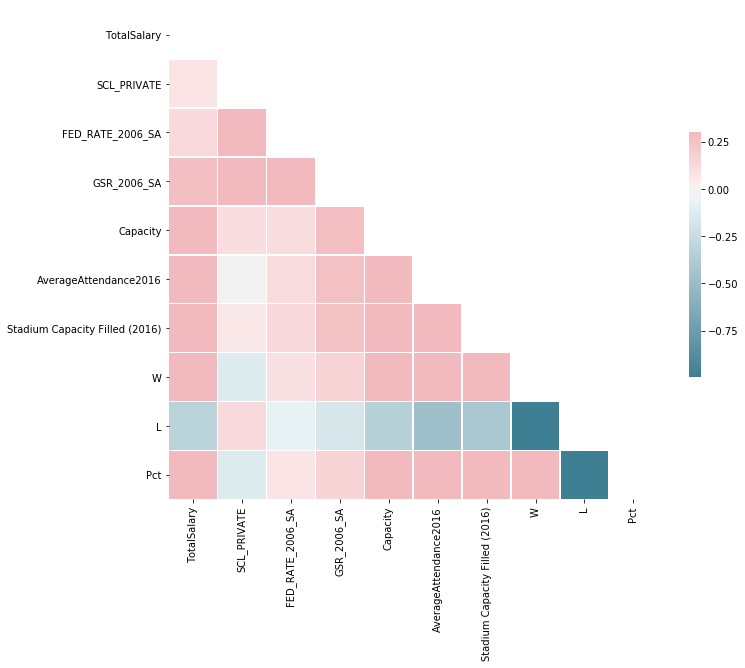

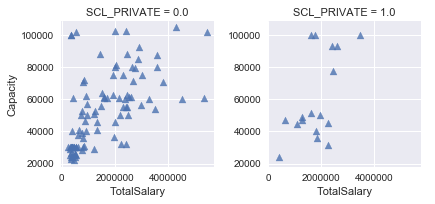

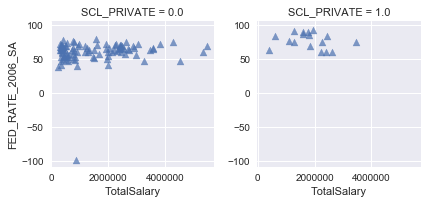

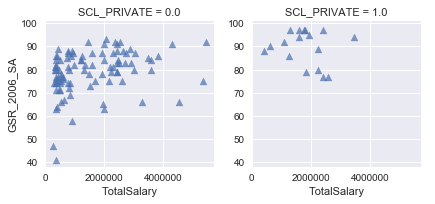

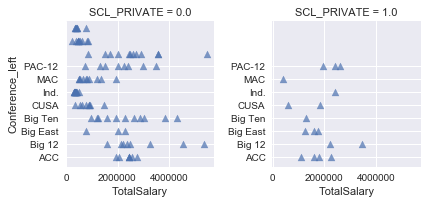

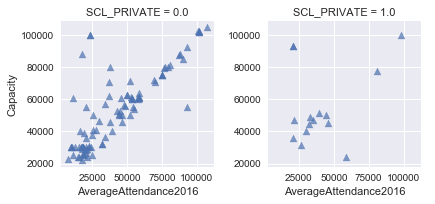

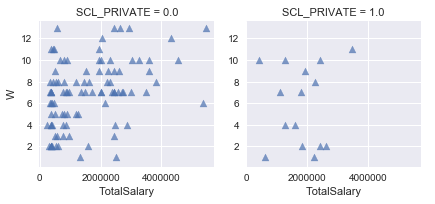

In [5]:
len(dfjoined) #87 rows of merged data remaining. Started with 124 coaches
import pylab

#print summary statistics
print(df.describe())

#simple boxplot for TotalSalary
sns.boxplot(y= "TotalSalary", x= "Conference_left", data= df)
plt.show()
pylab.savefig('foo.png')

#Create bar plot showing salary in relation to conference 
bp = sns.barplot('TotalSalary', 'Conference_left', data=df)
bp.set_xlabel = ('Conference')
bp.set_ylabel = ('TotalSalary')
bp.set_title = ('Salary By Conference')
plt.show()

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
#Increase size of output plt
fig_size[0] = 25
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

#Create bar plot showing wins by conference
bp = sns.barplot('W', 'TotalSalary', data=df)
bp.set_xlabel = ('TotalSalary')
bp.set_ylabel = ('W')
bp.set_title = ('Wins By TotalSalary')
plt.show()

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
#Increase size of output plt
fig_size[0] = 25
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

#Create correlation matrix - Code borrowed from week2 assignments
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

#Lattice plots w/ various yaxes - Code borrowed from week2 assignments
sns.set(style="darkgrid")
g = sns.FacetGrid(df, col="SCL_PRIVATE",                   
                  hue_kws=dict(marker=["^", "v"]))
g.map(plt.scatter, "TotalSalary", "Capacity", alpha=.8)
g.add_legend();
plt.show()

sns.set(style="darkgrid")
g = sns.FacetGrid(df, col="SCL_PRIVATE",                   
                  hue_kws=dict(marker=["^", "v"]))
g.map(plt.scatter, "TotalSalary", "FED_RATE_2006_SA", alpha=.7)
g.add_legend();
plt.show()

sns.set(style="darkgrid")
g = sns.FacetGrid(df, col="SCL_PRIVATE",                   
                  hue_kws=dict(marker=["^", "v"]))
g.map(plt.scatter, "TotalSalary", "GSR_2006_SA", alpha=.7)
g.add_legend();
plt.show()

sns.set(style="darkgrid")
g = sns.FacetGrid(df, col="SCL_PRIVATE",                   
                  hue_kws=dict(marker=["^", "v"]))
g.map(plt.scatter, "TotalSalary", "Conference_left", alpha=.7)
g.add_legend();
plt.show()

sns.set(style="darkgrid")
g = sns.FacetGrid(df, col="SCL_PRIVATE",                   
                  hue_kws=dict(marker=["^", "v"]))
g.map(plt.scatter, "AverageAttendance2016", "Capacity", alpha=.7)
g.add_legend();
plt.show()

sns.set(style="darkgrid")
g = sns.FacetGrid(df, col="SCL_PRIVATE",                   
                  hue_kws=dict(marker=["^", "v"]))
g.map(plt.scatter, "TotalSalary", "W", alpha=.7)
g.add_legend();
plt.show()





Linear Regressions w/ OLS 

In [12]:
#build a model to show all relevant variables
my_model = str('TotalSalary ~  School_right + Conference_left + Capacity + AverageAttendance2016 + W + L')

train_model_fit = smf.ols(my_model, data = df).fit()
print(train_model_fit.summary())
print(train_model_fit.params)





                            OLS Regression Results                            
Dep. Variable:            TotalSalary   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     1.476
Date:                Thu, 01 Feb 2018   Prob (F-statistic):              0.309
Time:                        03:49:10   Log-Likelihood:                -1521.1
No. Observations:                 110   AIC:                             3248.
Df Residuals:                       7   BIC:                             3526.
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [7]:
#Build Best Model
my_model1 = str('TotalSalary ~  Conference_left + Capacity + AverageAttendance2016 + W + L')
train_model_fit1 = smf.ols(my_model1, data = df).fit()
print(train_model_fit1.summary())
print(train_model_fit1.params)

                            OLS Regression Results                            
Dep. Variable:            TotalSalary   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     13.99
Date:                Thu, 01 Feb 2018   Prob (F-statistic):           7.03e-18
Time:                        03:46:03   Log-Likelihood:                -1627.9
No. Observations:                 110   AIC:                             3288.
Df Residuals:                      94   BIC:                             3331.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [8]:
df[df['School_right'].str.contains("Syracuse")]

,Name,School_right,Conference_left,TotalSalary,SCL_PRIVATE,FED_RATE_2006_SA,GSR_2006_SA,Capacity,AverageAttendance2016,Stadium Capacity Filled (2016),W,L,Pct
136,Doug Marrone,Syracuse University,Big East,1259276.0,1.0,75.0,86.0,49250.0,32805.0,0.67,4.0,8.0,0.333


Mixed Linear Model Regression

In [26]:
import statsmodels.formula.api as smf
df1 = df.dropna() #Mixed Linear cannot handle missing values


model3 = smf.mixedlm("TotalSalary ~ Capacity + AverageAttendance2016 + W + L", df1, groups=df1["Conference_left"])
  
model3fit = model3.fit()

print(model3fit.summary())

                         Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         TotalSalary      
No. Observations:          110             Method:                     REML             
No. Groups:                12              Scale:                      491347781086.9407
Min. group size:           1               Likelihood:                 -1603.4989       
Max. group size:           13              Converged:                  Yes              
Mean group size:           9.2                                                          
----------------------------------------------------------------------------------------
                           Coef.         Std.Err.    z    P>|z|    [0.025       0.975]  
----------------------------------------------------------------------------------------
Intercept                  -967784.587 2020012.654 -0.479 0.632 -4926936.637 2991367.463
Capacity                         7.306       4.

Basic regression model with a training and test set, but do not use conference as a predictor.

In [31]:
np.random.seed(111)
#Establishing cutpoints
df1['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(df1))
df_train = df1[df1['runiform'] >= 0.33]
df_test = df1[df1['runiform'] < 0.33]

my_model = str('TotalSalary ~ Capacity + AverageAttendance2016 + W + L')

# fit the model to the training set
train_model_fit = smf.ols(my_model, data = df_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())

#Print Predictions
train_model_fit.predict(df_test)




                            OLS Regression Results                            
Dep. Variable:            TotalSalary   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     17.15
Date:                Thu, 01 Feb 2018   Prob (F-statistic):           1.46e-09
Time:                        14:48:07   Log-Likelihood:                -1014.7
No. Observations:                  68   AIC:                             2039.
Df Residuals:                      63   BIC:                             2050.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -8.999e+

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1      6.242993e+05
4      8.075535e+05
5      2.056847e+06
6      2.618526e+06
8      3.481099e+06
12     1.006446e+06
13     3.611465e+06
17     2.618526e+06
20     8.909141e+05
21     1.828765e+06
35     1.483209e+06
37     8.986831e+05
42     9.286785e+05
44     1.919098e+06
52     2.926370e+06
55     1.242266e+06
60     1.497871e+06
67     1.097049e+06
68     9.539687e+05
69     1.677895e+06
77     1.600993e+06
79     3.475621e+06
85     1.426830e+06
87     2.056847e+06
89     1.544563e+06
90     8.405754e+05
91     7.960908e+05
106    3.094190e+06
117    2.675889e+06
120    8.294601e+05
124    7.190929e+05
125    1.220213e+06
129    1.784108e+06
134    2.326475e+06
136    1.269258e+06
139    3.004874e+06
149    2.060653e+06
153    1.927821e+06
154    1.744279e+06
156    3.611465e+06
161    6.015735e+05
164    8.865519e+05
dtype: float64

Attempt at creating geographical representation of salary by lat lon

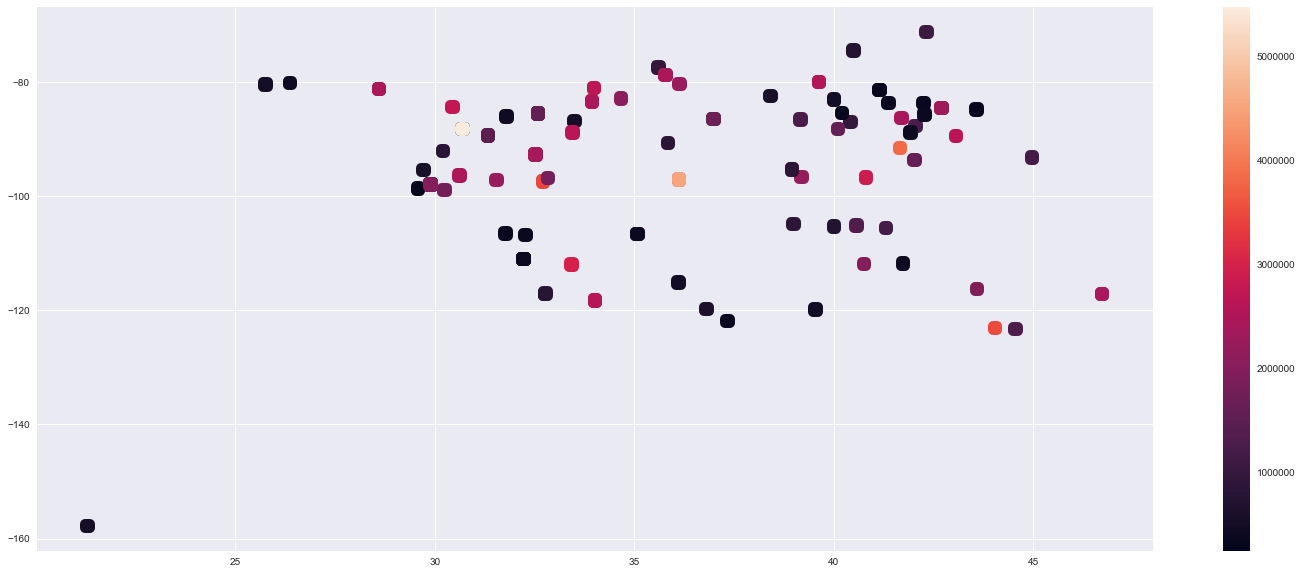

In [9]:
#I could not find college lat lon data, so I utilized a batch geocoding tool online at https://www.doogal.co.uk/BatchGeocoding.php
latlons = pd.read_csv('/Users/jdine/Desktop/SYracuse/Term 5 - Current/Advanced Info Analytics- IST 718/Homework/Lab1/LatLonsColleges.csv.')

#Merge lat lons onto dataframe
l_on1 = ["School_right"] 
r_on1= ["Address"]

df1 = fuzzymatcher.fuzzy_left_join(df , latlons, l_on1, r_on1) #Merge on School + address
df1

#basic scatterplot 
plt.scatter(df1['Latitude'], df1['Longitude'], marker = "s", c = df1['TotalSalary'], alpha = 1.0, linewidths = 10, s = 20)
plt.colorbar()
plt.show()

#Tried to use Basemap, but code was a little too advanced for 3d mapping, or 2d mapping with USA encoded onto map.


Additional Summary Graphs (Playing Around)

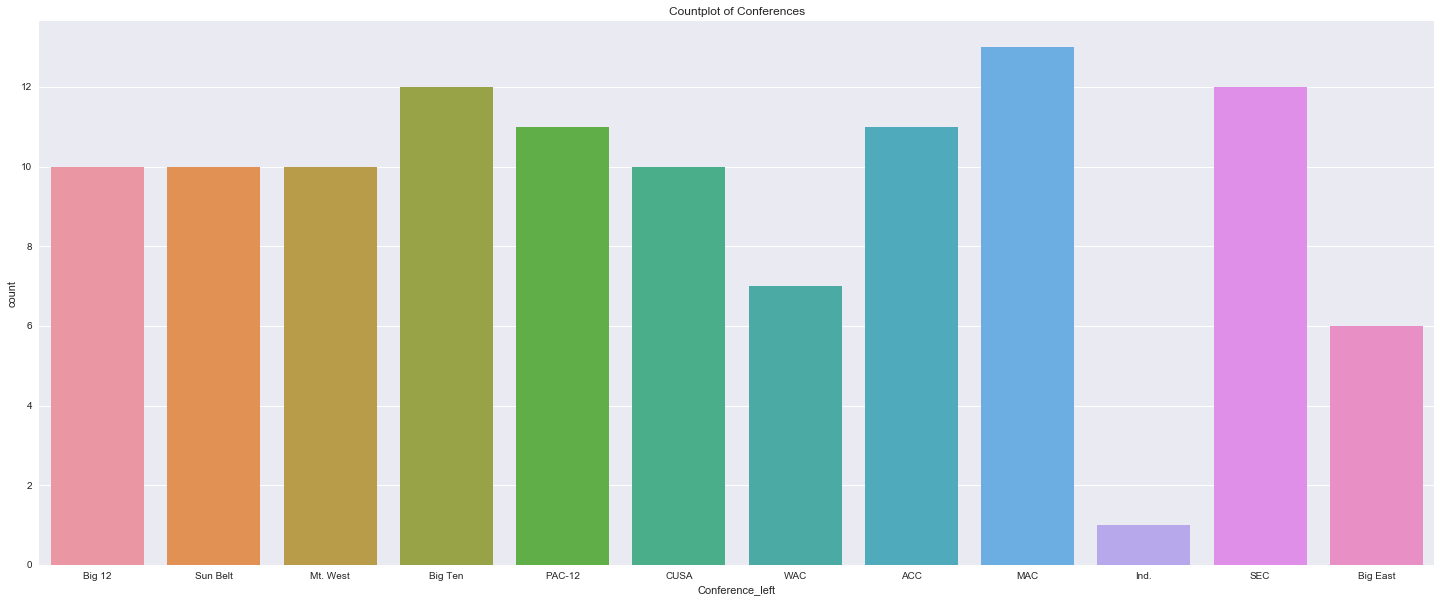

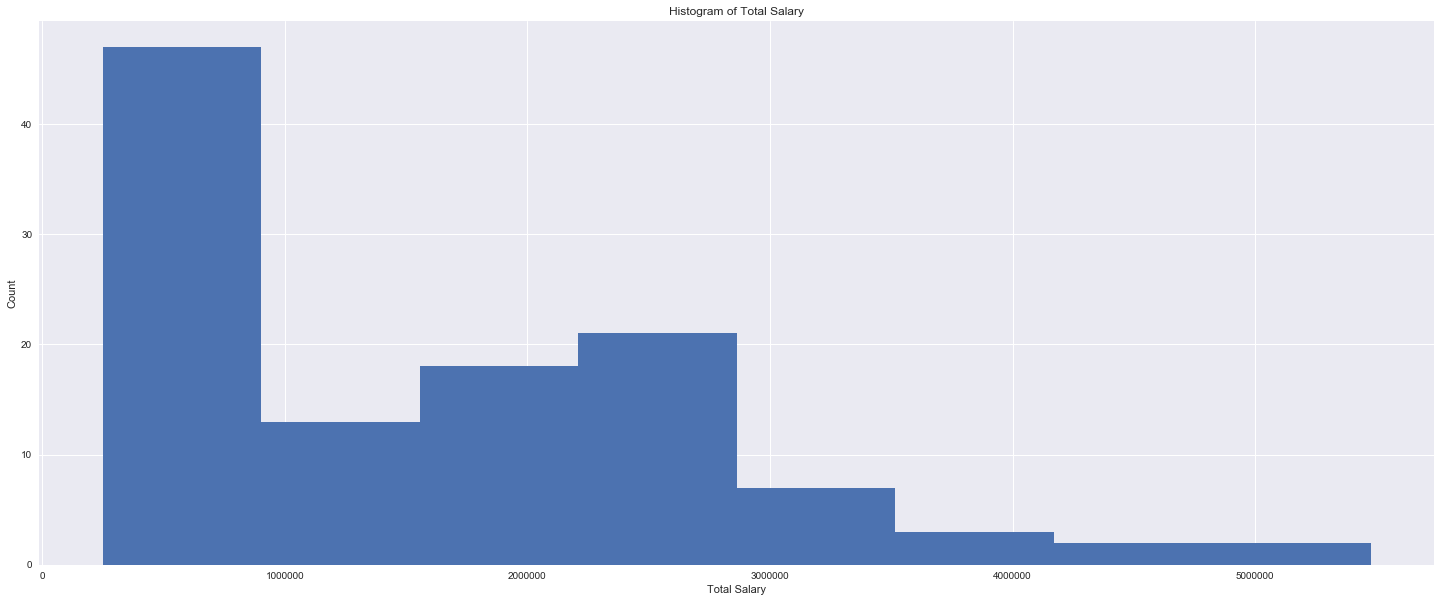

In [10]:
sns.countplot(x= 'Conference_left',  data = df)
sns.set(style="darkgrid")
plt.title("Countplot of Conferences")
plt.show()

plt.hist(df['TotalSalary'], bins = 'auto')
plt.title("Histogram of Total Salary")
plt.xlabel("Total Salary")
plt.ylabel("Count")
plt.show()